In [1]:
import torch
import torchvision                                                       
import torchvision.transforms as transforms

import os.path


In [2]:
############################################################################################ Datasets

dataset_dir = os.path.join(os.path.expanduser("D:\\AAA\\CS\\2020-2021\\apprentisage_profond"), 'Datasets', 'FashionMNIST')
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid

# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                           train=True,
                                           transform= None, #transforms.ToTensor(),
                                           download=True)

In [3]:
train_valid_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: D:\AAA\CS\2020-2021\apprentisage_profond\Datasets\FashionMNIST
    Split: Train

In [4]:
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])




In [5]:
print(f"nb_train,{nb_train},nb_valid,{nb_valid}")

nb_train,48000,nb_valid,12000


In [6]:
# Load the test set
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                                 transform= None, #transforms.ToTensor(),
                                                 train=False)

In [7]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: D:\AAA\CS\2020-2021\apprentisage_profond\Datasets\FashionMNIST
    Split: Test

In [8]:
class DatasetTransformer(torch.utils.data.Dataset):

    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)


train_dataset = DatasetTransformer(train_dataset, transforms.ToTensor())
valid_dataset = DatasetTransformer(valid_dataset, transforms.ToTensor())
test_dataset  = DatasetTransformer(test_dataset , transforms.ToTensor())

In [9]:
############################################################################################ Dataloaders
num_threads = 1    # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                           batch_size=batch_size,       # 每个batch有多少个样本
#                                           shuffle=True,                # <-- this reshuffles the data at every epoch 
#                                           num_workers=num_threads)     # 有几个进程来处理data loading

# valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=False,
#                                           num_workers=num_threads)


# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=False,
#                                           num_workers=num_threads)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,       # 每个batch有多少个样本
                                          shuffle=True                # <-- this reshuffles the data at every epoch 
                                          )     # 有几个进程来处理data loading

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


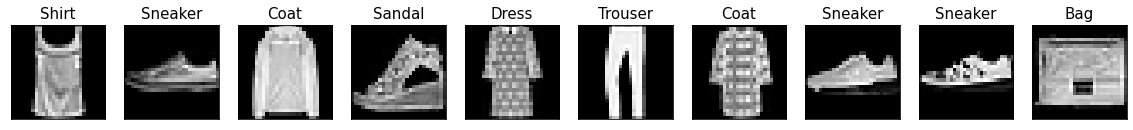

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nsamples=10
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imgs, labels = next(iter(train_loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('fashionMNIST_samples.png', bbox_inches='tight')
plt.show()

In [11]:
import torch.nn as nn

class LinearNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearNet, self).__init__()
        self.input_size = input_size
        self.classifier = nn.Linear(self.input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size()[0], -1)   # (a,b,c) -> 输出维度 (a,b*c)
        y = self.classifier(x)
        return y

model = LinearNet(1*28*28, 10)

use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


model.to(device)

D:\Anaconda\envs\gpu\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


LinearNet(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
# instantiate the loss :
f_loss = torch.nn.CrossEntropyLoss()


# instantiate the optimizer:
optimizer = torch.optim.Adam(model.parameters())

In [13]:
def train(model, loader, f_loss, optimizer, device):
    """
    Train a model for one epoch, iterating over the loader
    using the f_loss to compute the loss and the optimizer
    to update the parameters of the model.

    Arguments :

        model     -- A torch.nn.Module object
        loader    -- A torch.utils.data.DataLoader
        f_loss    -- The loss function, i.e. a loss Module
        optimizer -- A torch.optim.Optimzer object
        device    -- a torch.device class specifying the device
                     used for computation

    Returns :
    """

    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    model.train()

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute the forward pass through the network up to the loss
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()   # 清空过往梯度
        loss.backward()         # 反向传播，计算当前梯度
        optimizer.step()        # 根据梯度更新网络参数


# An example of calling train to learn over 10 epochs of the training set
for i in range(10):
    train(model, train_loader, f_loss, optimizer, device)

In [14]:
def test(model, loader, f_loss, device):
    """
    Test a model by iterating over the loader

    Arguments :

        model     -- A torch.nn.Module object
        loader    -- A torch.utils.data.DataLoader
        f_loss    -- The loss function, i.e. a loss Module
        device    -- The device to use for computation 

    Returns :

        A tuple with the mean loss and mean accuracy

    """
    # We disable gradient computation which speeds up the computation
    # and reduces the memory usage
    with torch.no_grad():
        # We enter evaluation mode. This is useless for the linear model
        # but is important with layers such as dropout, batchnorm, ..
        
        model.eval()  
       # 不启用 BatchNormalization 和 Dropout
       # 训练完train样本后，生成的模型model要用来测试样本。在model(test)之前，
       # 需要加上model.eval()，否则的话，有输入数据，即使不训练，它也会改变权值。
    
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):

            # We got a minibatch from the loader within inputs and targets
            # With a mini batch size of 128, we have the following shapes
            #    inputs is of shape (128, 1, 28, 28)
            #    targets is of shape (128)

            # We need to copy the data on the GPU if we use one
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass, i.e. the scores for each input image
            outputs = model(inputs)

            # We accumulate the exact number of processed samples
            N += inputs.shape[0]   # ([128, 1, 28, 28])

            # We accumulate the loss considering
            # The multipliation by inputs.shape[0] is due to the fact
            # that our loss criterion is averaging over its samples
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            # For the accuracy, we compute the labels for each input image
            # Be carefull, the model is outputing scores and not the probabilities
            # But given the softmax is not altering the rank of its input scores
            # we can compute the label by argmaxing directly the scores
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss/N, correct/N, correct

In [15]:
import sys
import random
import time

epochs = 5

def progress(loss, acc, correct):
    sys.stdout.write('Loss : {:2.4f}, Acc : {:2.4f}, Corect : {:2.4f}\r'.format(loss, acc,correct))
    sys.stdout.flush()
    
for t in range(epochs):
    # print("Epoch {}".format(t))
    train(model, train_loader, f_loss, optimizer, device)
    
    val_loss, val_acc,correct = test(model, valid_loader, f_loss, device)
    progress(val_loss, val_acc, correct)
    # print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))
sys.stdout.write('\n')  # sys.stdout的形式就是print的一种默认输出格式

Loss : 0.4117, Acc : 0.8562, Corect : 10274.0000


In [16]:
# Saving the best model

import os

def generate_unique_logpath(logdir, raw_run_name):
    i = 0
    while(True):
        run_name = raw_run_name + "_" + str(i)
        log_path = os.path.join(logdir, run_name)
        if not os.path.isdir(log_path):
            return log_path
        i = i + 1


###################################################
# Example usage :
# 1- create the directory "./logs" if it does not exist
top_logdir = "D:/AAA/CS/2020-2021/apprentisage_profond/logs"
if not os.path.exists(top_logdir):
    os.mkdir(top_logdir)

# 2- We test the function by calling several times our function
logdir = generate_unique_logpath(top_logdir, "linear")
print("Logging to {}".format(logdir))
# -> Prints out     Logging to   ./logs/linear_0
if not os.path.exists(logdir):
    os.mkdir(logdir)

logdir = generate_unique_logpath(top_logdir, "linear")
print("Logging to {}".format(logdir))
# -> Prints out     Logging to   ./logs/linear_1
if not os.path.exists(logdir):
    os.mkdir(logdir)

Logging to D:/AAA/CS/2020-2021/apprentisage_profond/logs\linear_2
Logging to D:/AAA/CS/2020-2021/apprentisage_profond/logs\linear_3


In [17]:
class ModelCheckpoint:

    def __init__(self, filepath, model):
        self.min_loss = None
        self.filepath = filepath
        self.model = model

    def update(self, loss):
        if (self.min_loss is None) or (loss < self.min_loss):
            print("Saving a better model")
            torch.save(self.model.state_dict(), self.filepath)
            #torch.save(self.model, self.filepath)
            self.min_loss = loss

###########################################
# Example usage 

# Define the callback object
model_checkpoint = ModelCheckpoint(logdir + "/best_model.pt", model)


# In the training loop 
for t in range(epochs):
    train(model, train_loader, f_loss, optimizer, device)
    model_checkpoint.update(val_loss)

Saving a better model


In [18]:
# Loading the best model

model_path = "D:/AAA/CS/2020-2021/apprentisage_profond/logs/linear_1/best_model.pt"
model = LinearNet(1*28*28, 10)

model = model.to(device)

model.load_state_dict(torch.load(model_path))

# Switch to eval mode 
model.eval()

test_loss, test_acc, _ = test(model, test_loader, f_loss, device)
print(" Test       : Loss : {:.4f}, Acc : {:.4f}".format(test_loss, test_acc))

 Test       : Loss : 0.4491, Acc : 0.8443


In [19]:
from torch.utils.tensorboard import SummaryWriter
 
# 模拟输入数据
x = torch.randn(128, 1, 28, 28)
x = x.view(x.size()[0], -1)
 
# 导入已有模型
model.load_state_dict(torch.load(model_path))

# Switch to eval mode 
model.eval()


# 声明writer对象，保存的文件夹，异己名称
writer = SummaryWriter(log_dir='D:/AAA/CS/2020-2021/apprentisage_profond/board/')
with writer:
    writer.add_graph(model, (x,))
test_loss, test_acc, _ = test(model, test_loader, f_loss, device)
    



In [21]:
for t in range(epochs):
    test_loss, test_acc, _ = test(model, test_loader, f_loss, device)

    writer.add_scalar('D:/AAA/CS/2020-2021/apprentisage_profond/val_loss', test_loss, t)
    writer.add_scalar('D:/AAA/CS/2020-2021/apprentisage_profond/val_acc',  test_acc, t)